In [124]:
import numpy as np
import pandas as pd
import pycountry

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.ticker as ticker

import os
from pathlib import Path

In [5]:
root = Path.cwd().parent.parent.parent / "cluster_data" / "breyer_sweep"

In [59]:
cdf = pd.concat([pd.read_csv(root / f"egs_costs_s_72_{year}.csv").set_index("name")[["capex_mean"]]
           .rename(columns={"capex_mean": year})
            for year in range(2020, 2055, 5)], axis=1)

cdf = cdf.loc[~cdf[2030].isna()]

In [85]:
factors = cdf.iloc[:,:-1].div(cdf.iloc[:,1:].values, axis=0).mean().tolist()

cum_factors = (
    np.around(
        np.array(
            [1] + [np.prod(factors[:i]) for i in range(1, len(factors)+1)]
            ),
        decimals=1)
    )

print(cum_factors)

[1.  1.4 1.8 2.5 3.5 4.4 5. ]


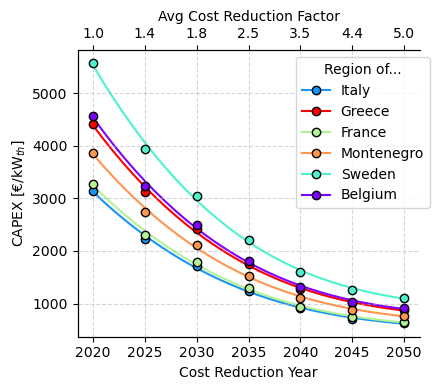

In [138]:
x = np.arange(cdf.columns[0], cdf.columns[-1]+1, 1, dtype=int)

n = 6
colors = cm.rainbow(np.linspace(0, 1, n))
np.random.shuffle(colors)

fig, ax = plt.subplots(figsize=(4.5, 4))

handles = []
labels = []

for c, bus in zip(colors, cdf.sample(n).index):

    fit = np.polyfit(cdf.columns, cdf.loc[bus], 3)

    ax.plot(x, np.polyval(fit, x), color=c, label=bus, zorder=0)
    ax.scatter(cdf.columns, cdf.loc[bus], marker="o", color=c, edgecolor="k")

    handles.append(plt.Line2D([0], [0], marker="o", color=c, markerfacecolor=c, markersize=6, markeredgecolor="k"))
    labels.append(pycountry.countries.get(alpha_2=bus[:2]).name)


ax.grid(True, linestyle="--", alpha=0.5)
ax.set_axisbelow(True)

ax.set_ylabel(r"CAPEX [€/kW$_{th}$]")
ax.set_xlabel("Cost Reduction Year")

ax1 = ax.twiny()
ax1.plot([2030, 2040], [3000, 3000], alpha=0)

ax1.xaxis.set_major_locator(ticker.FixedLocator(cdf.columns.tolist()))
ax1.set_xlabel("Avg Cost Reduction Factor")
ax1.set_xlim(ax.get_xlim())
ax1.set_xticklabels(np.array(cum_factors).astype(str))

ax.spines["right"].set_visible(False)
ax1.spines["right"].set_visible(False)

ax.legend(
    handles, labels, loc="upper right", bbox_to_anchor=(1.05, 1), title="Region of..."
)

plt.tight_layout()
plt.savefig("schematic_cost_reduction.pdf")
plt.show()